In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
np.random.seed(1234)
%matplotlib inline


Group A are histological slides, group B are fluorescent images, and group C are bright-field images. 

It looks we have the following breakdown:

fluorescent: 81.5%
histological: 16.1%
bright-field: 2.4%

In [2]:
STAGE1_TRAIN = "./stage1_train"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

In [3]:
#Function loads images. Keep only RGB channels as Alpha channel is always empty.

def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids



def read_image(image_id, space="rgb"):
    image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    image = image[:, :, :3]  # Drop alpha 
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [4]:
# Get image width, height and count masks. 
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels, num_masks

In [5]:
# Load stage 1 image identifiers.
train_image_ids = image_ids_in(STAGE1_TRAIN)
train_image_ids.pop(0)

'.DS_Store'

In [6]:
def get_domimant_colors(img, top_colors=2):
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

In [7]:
def get_images_details(image_ids):
    details = []
    for image_id in image_ids:
        image_hsv, labels, num_masks = read_image_labels(image_id, space="hsv")
        height, width, l = image_hsv.shape
        dominant_colors_hsv, dominant_rates_hsv = get_domimant_colors(image_hsv, top_colors=1)
        dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
        info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
        details.append(info)
    return details

In [8]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [9]:
details = get_images_details(train_image_ids)

#This is a bottleneck function because k means is very slow. 
# using libKMCUDA import kmeans_cuda can speed this up

In [10]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

In [11]:
trainPD.head()

,image_id,width,height,total_masks,hsv_dominant,hsv_cluster
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,256,256,27,"[0.0, 0.0, 0.024087165383729188]",0
1,003cee89357d9fe13516167fd67b609a164651b2193458...,256,256,36,"[0.0, 0.0, 0.03536706064261729]",0
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,320,256,70,"[0.6969922721241344, 0.2417388976327308, 0.760...",1
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,320,256,86,"[0.6439642758207023, 0.21017601724122453, 0.80...",1
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,320,256,7,"[0.7435220601544178, 0.23248918633236715, 0.78...",1


In [12]:
def plot_images(images, images_rows, images_cols):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = images[row*images_cols + col]
            image = read_image(image_id)
            height, width, l = image.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(image)

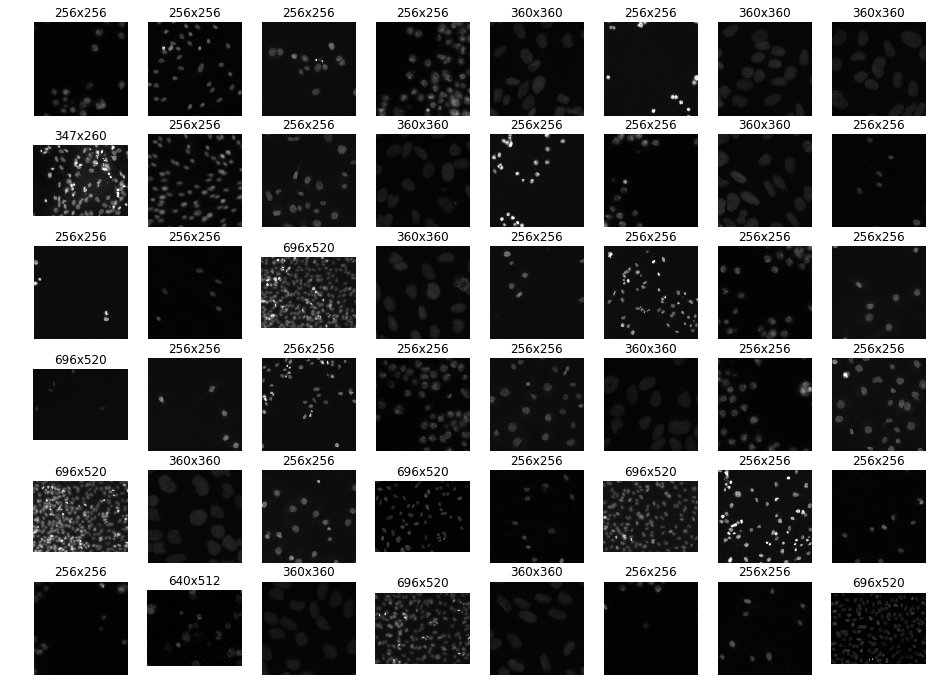

In [13]:

plot_images(trainPD[trainPD[HSV_CLUSTER] == 0][IMAGE_ID].values, 6, 8)

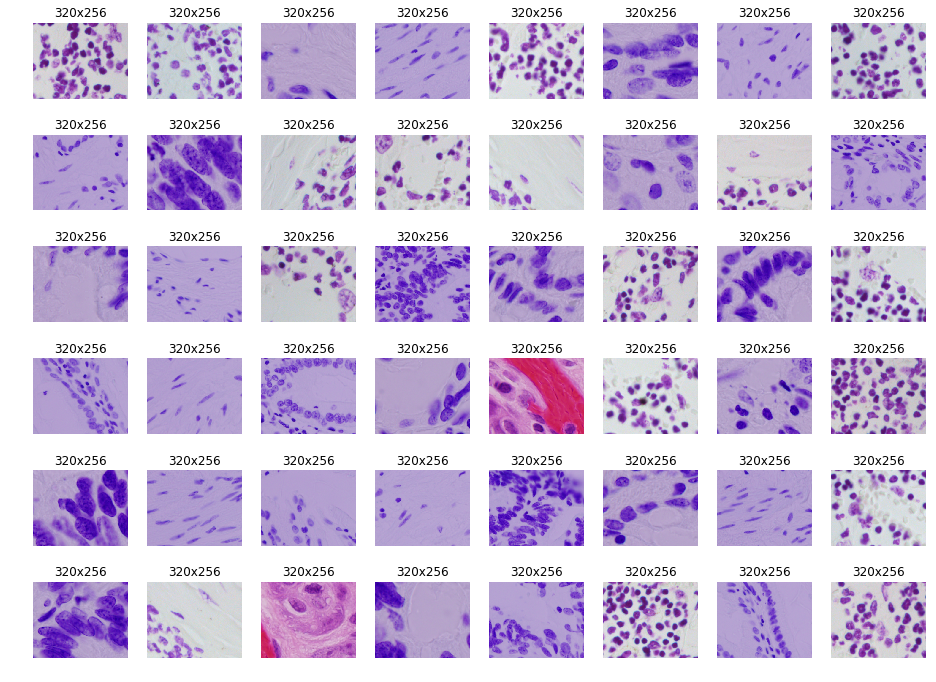

In [32]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 1][IMAGE_ID].values, 6, 8)

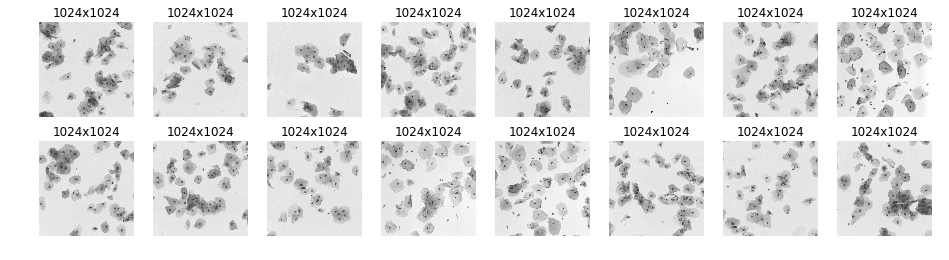

In [33]:
plot_images(trainPD[trainPD[HSV_CLUSTER] == 2][IMAGE_ID].values, 2, 8)

In [34]:

P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
P

,hsv_cluster,image_id,Percentage
0,0,546,81.492537
1,1,108,16.119403
2,2,16,2.388060
